### Импорт данных

**Выгрузка представленных данных**

In [75]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from numpy import NaN

In [2]:
data = pd.read_csv("traks.csv",sep='\;')

C:\Users\blend\AppData\Local\Temp\ipykernel_26276\778844095.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("traks.csv",sep='\;')


In [3]:
data.head()

,track,time,x,y
0,1,10:32:13,1598,526
1,1,10:32:14,1524,544
2,1,10:32:15,1441,557
3,1,10:32:16,1357,392
4,1,10:32:17,1395,573


**Обработка данных**

*Для начала, столбец time делаем индексным*

In [50]:
data.set_index('time', inplace=True)

*Далее, для простоты работы, разделяем данные на четыре dataframe, с различными траекториями. Всего dataframe получиться четыре, так, как траектории четыре.*

In [52]:
track_1 = data[data['track'] == 1]
track_2 = data[data['track'] == 2]
track_3 = data[data['track'] == 3]
track_4 = data[data['track'] == 4]

*Ради интереса посмотрим размерность получившихся данных*

In [53]:
print(track_1.shape)
print(track_2.shape)
print(track_3.shape)
print(track_4.shape)

(35, 3)
(27, 3)
(33, 3)
(19, 3)


### Визуализация

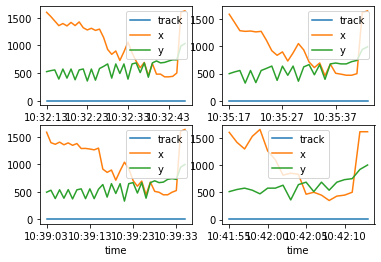

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2)
track_1.plot(ax=axes[0,0])
track_2.plot(ax=axes[0,1])
track_3.plot(ax=axes[1,0])
track_4.plot(ax=axes[1,1])
plt.show()

### Алгоритм для сравнения путей

In [60]:
# Функция для интерполяции траектории 
def df_interpolate(data):
    prev_index = 0 # Переменная для сохранения предыдущего значения индекса
    counter = 0 # Переменная для числового доступа (enumerate неприменим к .iterrows)
    # Иттерация по каждой строке 
    for index, row in data.iterrows():
        counter =+1
        if index == prev_index:              # В случае совпадения текущего значения индекса с предыдущим
            data.iloc[[counter]] = NaN    # Значение строки = NaN
        prev_index = index
    return data.interpolate(method = "linear") # Линейная интерполяция пустых значений

In [61]:
# Функция для создания новых индексов 
def get_new_index(start, end, size):
    dates = []
    index = pd.date_range(start = start, end = end, periods = size) # Указываем нужный период и количество промежутков
    # Конвертация datetime к формату h:m:s
    for i in index:
        dates.append(f"{i.hour}:{i.minute}:{i.second if i.second >= 10 else '0' + str(i.second)}")  
    return dates

In [62]:
# Функция для сравнения двух траекторий
def compare_tracks(first_track, second_track):
 
    # Сравниваем размер треков - нужно выделить больший и меньший
    # Если первая траектория больше (по количеству точек):
    if first_track.shape[0] > second_track.shape[0]:
        size = first_track.shape[0]   # Возьмем размер наибольшей траектории
        start = second_track.index[0]  # Начальный период измерений наименьшей точки
        end = second_track.index[-1]    # Конечный период измерений наименьшей точки
        second_track = second_track.reindex(get_new_index(start, end, size)) # Обновим меньшую траекторию (новые индексы)
        second_track = df_interpolate(second_track)  # Интерполяция наименьшей траектории
    # Аналогично для обратного случая
    elif first_track.shape[0] < second_track.shape[0]:
        size = second_track.shape[0]
        start = first_track.index[0]
        end = first_track.index[-1]
        first_track = first_track.reindex(get_new_index(start, end, size))
        first_track = df_interpolate(first_track) 
    # Для определения степени схожести путей используем R2-score
    return r2_score(first_track[["x","y"]], second_track[["x","y"]])

In [65]:
# Сравним совпадение 1 и 3 траектории
compare_tracks(track_1, track_3)

0.8823639256234281

In [66]:
# Отличие 1 и 2 траектории
compare_tracks(track_1, track_2)

0.4542259725998696

In [67]:
# Существенное отличие от 4 траектории
compare_tracks(track_4, track_3)

0.3023663653145285